In [1]:
# Импорт необходимых библиотек
import cv2
import numpy as np
import os
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction
from pathlib import Path
from boxmot import DeepOCSORT
from IPython.display import display, Image

In [2]:
#Инициализация модели детектирования и трекера

tracker = DeepOCSORT(
    model_weights=Path('osnet_x0_25_msmt17.pt'),
    device='cpu',
    fp16=False,
)

detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov8',
    model_path='/Users/stepan/Desktop/Dataset_do/best (9).pt',
    confidence_threshold=0.5,
    device="cpu",
)

print(detection_model)

2024-03-31 18:31:40.536 | SUCCESS  | boxmot.appearance.reid_model_factory:load_pretrained_weights:207 - Successfully loaded pretrained weights from "osnet_x0_25_msmt17.pt"
2024-03-31 18:31:40.536 | WARNING  | boxmot.appearance.reid_model_factory:load_pretrained_weights:211 - The following layers are discarded due to unmatched keys or layer size: ('classifier.weight', 'classifier.bias')


In [3]:
# Функция для создания многоугольной маски

def create_polygon_mask(image_shape, points):
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    points = np.array(points, dtype=np.int32)
    cv2.fillPoly(mask, [points], 255)
    return mask

In [4]:
# Задание параметров камеры
vid = cv2.VideoCapture("/Users/stepan/Desktop/Dataset_do/video/file10.mp4")
vid.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
vid.set(cv2.CAP_PROP_FRAME_HEIGHT, 360)

# Определение точек области очереди
roi_points = [(10, 50), (200, 50), (1048, 100), (1048, 580), (350, 300), (300, 250), (10, 250)]

Performing prediction on 18 number of slices.


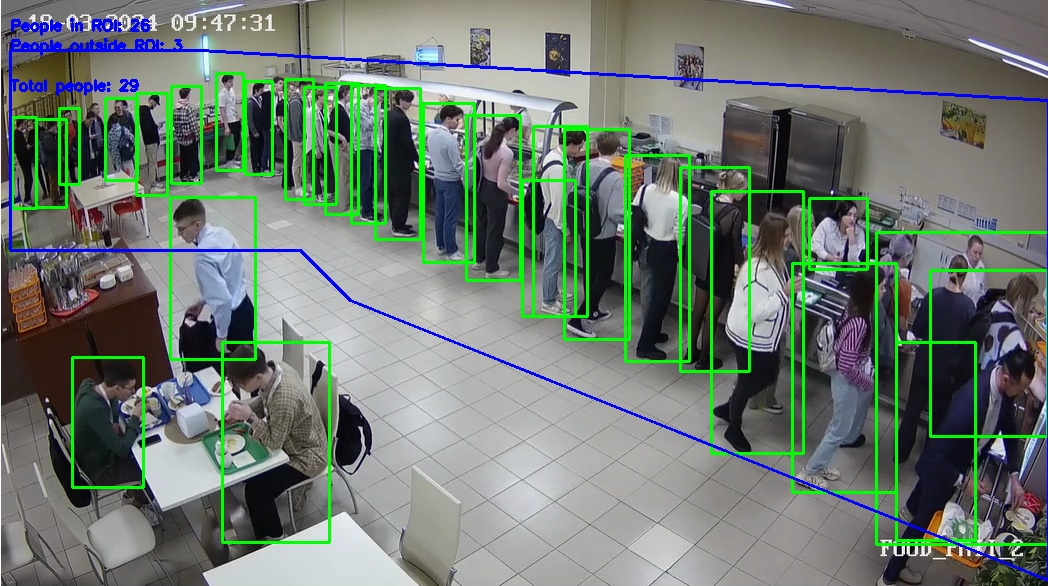

In [6]:
# Основной цикл обработки кадров видео

people_detected_in_roi = 0
people_detected_outside_roi = 0

for i in range(1):
    ret, im = vid.read()
    if not ret:
        break

    # Создание многоугольной маски
    mask = create_polygon_mask(im.shape, roi_points)
    outside_roi_mask = cv2.bitwise_not(mask)
    outside_roi_area = cv2.bitwise_xor(im, im, mask=outside_roi_mask)
    
    # Получение результатов детекции
    result = get_sliced_prediction(
        im,
        detection_model,
        slice_height=256,
        slice_width=256,
        verbose=1,
        overlap_height_ratio=0.3,
        overlap_width_ratio=0.3
    )

    # Преобразование результатов детекции в треки
    dets = np.zeros([len(result.object_prediction_list), 6], dtype=np.float32)

    for ind, object_prediction in enumerate(result.object_prediction_list):
        bbox = object_prediction.bbox.to_voc_bbox()
        dets[ind, :4] = bbox
        dets[ind, 4] = object_prediction.score.value
        dets[ind, 5] = object_prediction.category.id

        cv2.rectangle(im, (int(dets[ind, 0]), int(dets[ind, 1])), (int(dets[ind, 2]), int(dets[ind, 3])), (0, 255, 0), 2)
        
    # Отображение области очереди
    cv2.polylines(im, [np.array(roi_points)], True, (255, 0, 0), 2)

    tracks = tracker.update(dets, im)

    if tracks.shape[0] != 0:
        xyxys = tracks[:, 0:4].astype('int')
        ids = tracks[:, 4].astype('int')
        confs = tracks[:, 5].round(decimals=2)
        clss = tracks[:, 6].astype('int')

        for xyxy, id, conf, cls in zip(xyxys, ids, confs, clss):
            r = []
            x1, y1, x2, y2 = xyxy

            # В цикле обработки кадра
            center_x, center_y = int((x1 + x2) / 2), int((y1 + y2) / 2)

            # Проверяем принадлежность точки маске ROI

            is_inside_roi = mask[center_y, center_x] > 0

            if is_inside_roi:
                people_detected_in_roi += 1

            else: 
                people_detected_outside_roi += 1 

    # Отображение количества людей
    cv2.putText(im, f'People in ROI: {people_detected_in_roi}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    cv2.putText(im, f'People outside ROI: {people_detected_outside_roi}', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    cv2.putText(im, f'Total people: {people_detected_outside_roi + people_detected_in_roi}', (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Область вне интереса с изображением для отображения
    im_with_roi = cv2.addWeighted(im, 1, outside_roi_area, 1, 0)

    # Отображение результата в Jupyter Notebook
    _, jpg_image = cv2.imencode('.jpg', im_with_roi)
    display(Image(data=jpg_image))

# Освобождаем камеру и закрываем все окна
vid.release()
cv2.destroyAllWindows()